# Examples of numerical simulations of Brownian particles trajectories

## Introduction

The overdamped Langevin equation describes the random motion (called "[Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion)") of a micron-size object immersed in a viscous fluid, and submitted to the thermal agitation of this fluid's molecules. 

The function **Brownain_simu** integrates this equation, to generate random trajectories of Brownian particles. In addition to the thermal agitation, the particle can be submitted to an external force field (that depends on the particle's position), and to an external noise (that can vary in time, but is the same for all positions). For simplicity, only the case of spherical particles is considered (the Langevin equation can also be used with non-spherical objects, but it generally requires to modify the Stokes term $\gamma = 6\pi R \mu$ accordingly).

In this example file, we show how to use the function to:
1. [Compute the trajectories of free particles](#free) 
2. [Compute the trajectories of particles held in an optical trap](#trap)
3. [Compute the trajectories of particles submitted to a sinusoidal forcing](#sinus)
4. [Compute the trajectories of particles held in an optical trap and submitted to a colord noise](#color)

## Importing the function

We start by importing some general use libraries (numpy and matplotlib.pyplot) as well as the function "Brownian_simu":

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Numerical_Simulations_Langevin_Equation import Brownian_simu

To know how to use the simulation function, we show the help documentation:

In [2]:
help(Brownian_simu)

Help on function Brownian_simu in module Numerical_Simulations_Langevin_Equation:

Brownian_simu(nb_part=100, duration=1, dt=1e-05, x_0=[], r=1.5e-06, eta=0.001, k_B=1.381e-23, T=298.15, ext_F=<function <lambda> at 0x0000017F2CA359D8>, ext_noise=[], on_plot=False, nb_plot=10)
    Brownian_simu(nb_part=100,duration=1,dt=1e-5,x_0=[],r=1.5e-6,eta=1e-3,k_B=1.381e-23,T=298.15,ext_F=lambda x:np.zeros_like(x),ext_noise=[],on_plot=False,nb_plot=10)
    
    Computes the 1D trajectory of a Brownian particle, by integrating with Heun scheme [1] the overdamped Langevin equation:
        gamma * dX/dt = external_force + external_noise + thermal_noise
    where: 
    - X is the particle's position
    - t is the time
    - gamma is the Stokes drag coefficient (gamma = 6*pi*R*eta with R the particle's radius and eta the fluid's viscosity)
    - external_force is a deterministic function of X
    - external_noise is a term that may vary with time but is independent of X
    - thermal_noise is a Gauss

## <a name="free"></a> 1) Trajectories of free particles

Here we simulate the trajectory of a "free" Brownian particle, whichm eans that the particle is only submitted to thermal agitation.  
We start by simulating the trajectory of one 1 µm size particle in water at room temperature:

In [3]:
nb = 1 #number of particles
radius = 1e-6 #m
T = 298.5 #K (25°C)
k_B = 1.380649e-23 #J/K (Boltzmann constant)
viscosity = 1e-3 #Pa.s (viscosity of water)
t = 10 #s (duration)
dt= 1e-3 #s (numerical time step for the integration)

traj_x,time = Brownian_simu(nb_part=nb,duration=t,dt=dt,r=radius,eta=viscosity,T=T)

We then plot the result:

Text(0, 0.5, 'Position (µm)')

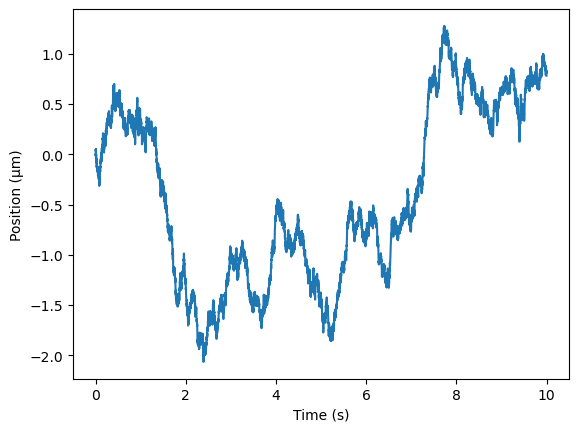

In [4]:
plt.plot(time,traj_x[0,:]*1e6)
plt.xlabel('Time (s)')
plt.ylabel('Position (µm)')

We can also generate several trajectories, and directly plot a subset of them with the optional input argument "on_plot":

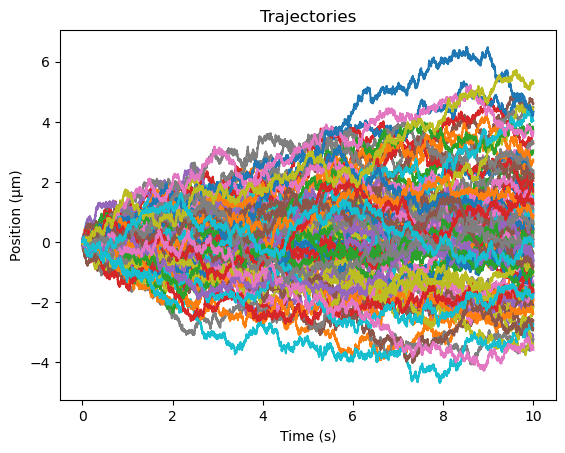

In [5]:
nb = 1000 #the number of trajectories that will be generated
nb_plot=100 #the number of trajectories that will directly be plotted

traj_x,time = Brownian_simu(nb_part=nb,duration=t,dt=dt,r=radius,eta=viscosity,T=T,on_plot=True,nb_plot=nb_plot)

Then, we can for example compute the time evolution of the position variance, to verifiy that it is linear in time:  
$\langle x(t)^2 \rangle = 2Dt$  
where $D = k_\mathrm{B}T/\gamma$ is the particle's equilibrium diffusion coefficient).

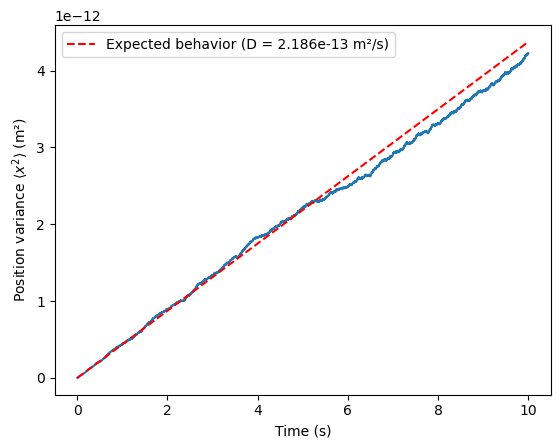

In [6]:
variance = np.var(traj_x,0) #compute the variance

D = k_B*T/(6*np.pi*radius*viscosity) #expected value of the diffusion coefficient

plt.plot(time,variance)
plt.plot(time, time*2*D,'r--',label='Expected behavior (D = {:.4} m²/s)'.format(D))
plt.xlabel('Time (s)')
plt.ylabel(r'Position variance $\langle x^2 \rangle$ (m²)')
plt.legend()

## <a name="trap"></a> 2) Trajectories of particles held in an optical trap

Here we consider a particle that is held in an optical trap.  
This is modeled by adding a spring-like force $F(x) = -k \times x$ (with $k$ the trap stiffness) acting on the particle (for simplicity, we assume here that the trap position is in x = 0).

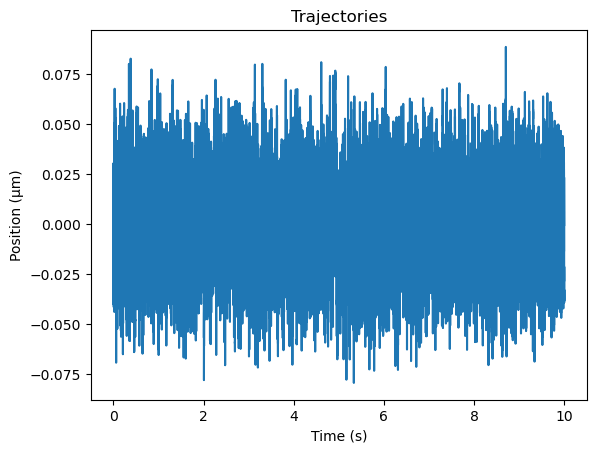

In [7]:
nb = 1 #number of particles
radius = 1e-6 #m
T = 298.5 #K (25°C)
k_B = 1.380649e-23 #J/K (Boltzmann constant)
viscosity = 1e-3 #Pa.s (viscosity of water)
t = 10 #s (duration)
dt= 1e-5 #s (numerical time step for the integration)

k = 10e-6 #N/m

#We define the force that will be acting on the particle:
def spring_force(x):
    return -k*x

traj_x,time = Brownian_simu(nb_part=nb,duration=t,dt=dt,r=radius,eta=viscosity,T=T,ext_F=spring_force, on_plot=True)

Then, we can for example verify that the (normalized) distribution of the particle's position follows the Gibb's distribution:  
$P(x) = \exp(-\frac{kx^2}{2k_\mathrm{B}T})$

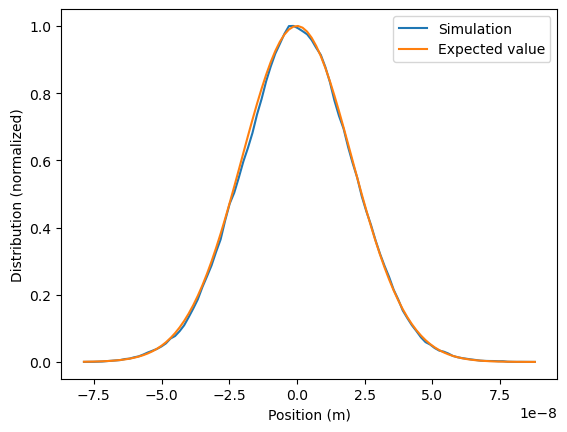

In [8]:
hist,hist_axe = np.histogram(traj_x[0,:],100) #compute the distribution

position=(hist_axe[:-1]+hist_axe[1:])/2 #center of the bins for the distribution

plt.plot(position,hist/np.max(hist),label='Simulation')
plt.plot(position, np.exp(-k*position**2/(2*k_B*T)),label='Expected value')
plt.xlabel('Position (m)')
plt.ylabel('Distribution (normalized)')
plt.legend()

## <a name="sinus"></a> 3) Trajectories of particles submitted to a sinusoidal forcing

Here we consider a particle that is submitted to a time-dependent external forcing.  
We choose to study the effect of a sinusoidal forcing (acting on all positions) of the form: $F(t) = A \times \sin(\omega t)$.

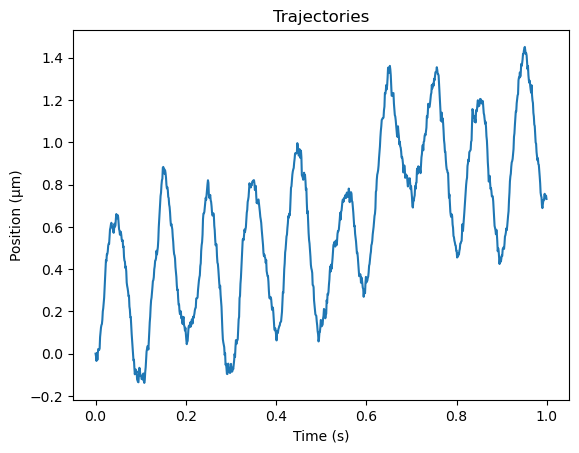

In [9]:
nb = 1 #number of particles
radius = 1e-6 #m
T = 298.5 #K (25°C)
k_B = 1.380649e-23 #J/K (Boltzmann constant)
viscosity = 1e-3 #Pa.s (viscosity of water)
t = 1 #s (duration)
dt= 1e-3 #s (numerical time step for the integration)

#We compute the value of the external force at each time-step:
A = 100*k_B*T/radius #Amplitude of the force
w0 = 2*np.pi*10 #rad/s (corresponds to a frequency of 10 Hz)
nb_time_increment=np.round(t/dt) #number of points that will be simulated given t and dt
time_force = np.arange(nb_time_increment)*dt #time vector
sin_force = A*np.sin(time_force*w0)

traj_x,time = Brownian_simu(nb_part=nb,duration=t,dt=dt,r=radius,eta=viscosity,T=T,ext_noise=sin_force,on_plot=True)

We can also generates several trajectories simultaneously, given that we provide an external force for each particle:

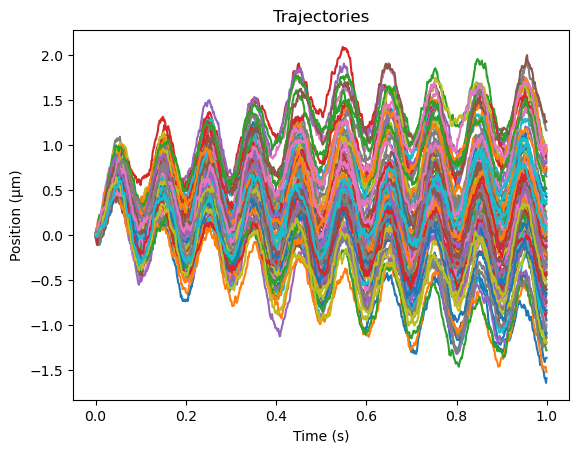

In [10]:
nb = 1000 #the number of trajectories that will be generated
nb_plot=100 #the number of trajectories that will directly be plotted

#We compute the value of the external force at each time-step for each particle:
A = 100*k_B*T/radius #Amplitude of the force
w0 = 2*np.pi*10 #rad/s (corresponds to a frequency of 10 Hz)
nb_time_increment=np.round(t/dt) #number of points that will be simulated given t and dt
time_force = np.arange(nb_time_increment)*dt #time vector
sin_force = A*np.sin(time_force*w0) * np.ones((nb,len(time_force))) #here the sinusoidal force as a dimension (nb x nb_time_increment)

traj_x,time = Brownian_simu(nb_part=nb,duration=t,dt=dt,r=radius,eta=viscosity,T=T,ext_noise=sin_force,on_plot=True,nb_plot=nb_plot)

## <a name="color"></a> 4) Trajectories of trapped particles submitted to a colored noise

Here we consider a Brownian particle, held in an optical trap, and submitted to an external colored noise.

First, we choose the colored noise to be an exponentially correlated Gaussian noise with correlation time $\tau_c = 10^{-3}$ $\mathrm{s}$. We generate it using the function **colored_noise_simu**.

In [11]:
from Numerical_Simulations_Langevin_Equation import colored_noise_simu

help(colored_noise_simu)

Help on function colored_noise_simu in module Numerical_Simulations_Langevin_Equation:

colored_noise_simu(n_traj=1, dt=1e-05, duration=1, alpha=1, fc=100)
    colored_noise_simu(n_traj=1,dt=1e-5,duree=1,alpha=1,fc=100)
    
    Generates a colored noise X by integrating with Heun scheme [1] the overdamped Langevin equation:
        dX/dt = - wc * X + \sqrt(2*alpha*wc) * eta
    where wc = 2*pi*fc and eta is a Gaussian white noise with variance equal to 1
    
    Input parameters :
        - n_traj : number of noise samples one wants to create (int)
        - dt : time step for noise samples (s)
        - duration : duration of each sample (s)
        - alpha : finale variance of the colored noises
        - fc : cut-off frequency of the colored noises
        
    Output :
        - X : array of dimension "n_traj x int(duree/dt)" that contains n_traj independent samples of colored noise with the chosen duration
        
    [1] Mannella, R. (2002). Integration of stochastic different

In [12]:
nb = 1 #number of particles
t = 1 #s (duration)
dt= 1e-5 #s (numerical time step for the integration)
F_cut = 1000 #cut-off frequency of the colored noise (Hz)
A = 1000*k_B*T/radius #amplification of the colored noise (Da = Ca*D, with D the equilibrium diffusion coefficient of the particle)

nb_time_increment=int(np.round(t/dt))

colored_noise=A*colored_noise_simu(n_traj=nb,dt=dt,duration=t,alpha=1,fc=F_cut)

We can look at the Power Spectral Density (PSD) of the noise to verify that it, indeed, a colored noise, with most of its power below the cut-off frequency $f_c = 1/\tau_c$:

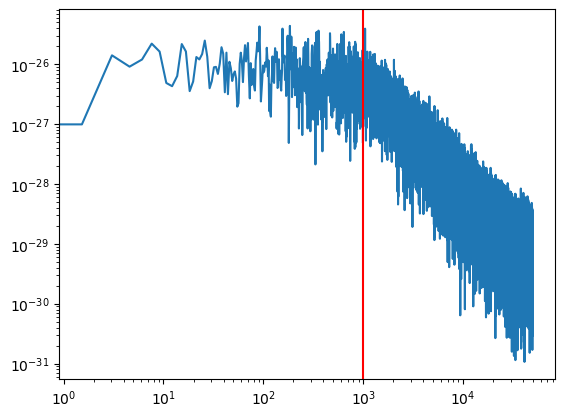

In [13]:
import scipy.signal as sig

N_spectre=2**16

f,spectrum=sig.welch(colored_noise,1/dt, window='hann', nperseg=N_spectre)

plt.loglog(f,spectrum[0,:],label="Simulated PSD")
plt.axvline(F_cut, color='red',label="Cut-off frequency")

Then, we simulate the trajectory of a particle held in an optical trap and submitted to the colored noise:

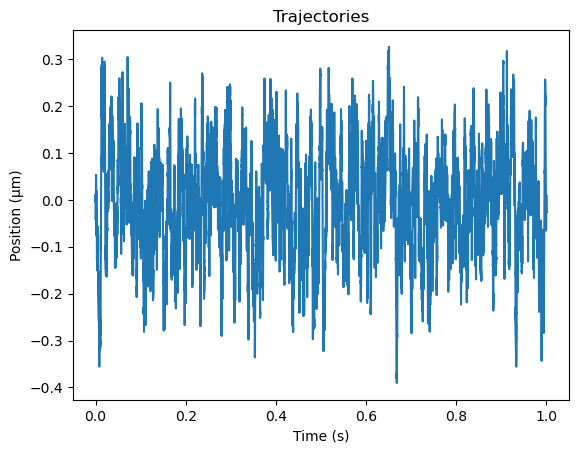

In [14]:
radius = 1e-6 #m
T = 298.5 #K (25°C)
k_B = 1.380649e-23 #J/K (Boltzmann constant)
viscosity = 1e-3 #Pa.s (viscosity of water)

k = 10e-6 #N/m

#We define the force that will be acting on the particle:
def spring_force(x):
    return -k*x

traj_x,time = Brownian_simu(nb_part=nb,duration=t,dt=dt,r=radius,eta=viscosity,k_B=k_B,T=T,ext_F=spring_force,ext_noise=colored_noise,on_plot=True)

Finally, we can plot the PSD of the particle's position to verify that it is different from the expected equilibrium PSD (especially, at frequencies that are below the cut-off frequency of the colored noise):

Text(0, 0.5, 'PSD (m²/Hz)')

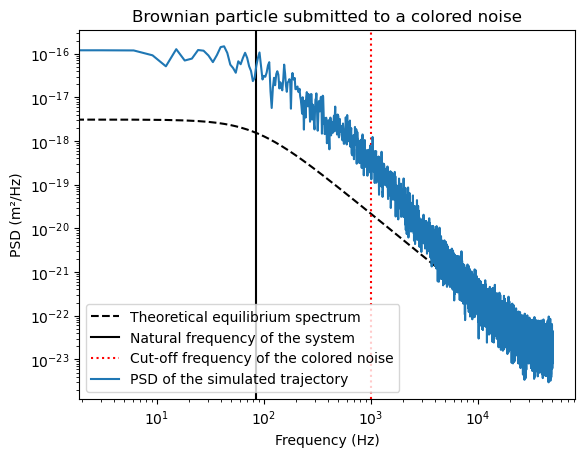

In [15]:
N_spectre=2**15 #number of points for the computation of the power spectrum with Welch's method

f0 = k/(6*np.pi*radius*viscosity*2*np.pi) #natural frequency of the Brownian particle in the optical trap
D = k_B*T/(6*np.pi*radius*viscosity) #equilibrium diffusion coefficient

f,spectrum=sig.welch(traj_x,1/dt, window='hann', nperseg=N_spectre)

plt.figure()
plt.loglog(f,(4*D/((2*np.pi*f)**2+(2*np.pi*f0)**2)),'k--',label="Theoretical equilibrium spectrum")
plt.axvline(f0, color='black',label="Natural frequency of the system")
plt.axvline(F_cut, color="red",linestyle='dotted',label="Cut-off frequency of the colored noise")
plt.loglog(f,spectrum[0,:],label="PSD of the simulated trajectory")
plt.legend(loc="lower left")
plt.title('Brownian particle submitted to a colored noise')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')